# Experimento 3:
Para ejecutar este notebook es necesario haber compilado el código previamente. Esto se puede hacer fácilmente ejecutando la primera celda del notebook Análisis Preliminar
## Nueva feature: amante_del_agua -> mejora la predicción del precio ?
En esta sección exploramos los beneficios del feature engineering en la creacion de modelos de regresiones lineales.

## Cargamos los datos del dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import metnum

# Carguemos el dataset al igual que en experimentos anteriores
df_train = pd.read_csv("../data/train.csv")

In [2]:
# Importamos las funciones necesarias desde otro archivo nuestro
from extra_scripts import cross_validate, rmse, rmsle

In [3]:
# Copiamos la funcion del Exp2 para imprimir en Veracruz
import matplotlib.image as mpimg
def plot_map (df_pred, save_name = None, title = None, dot_size = 50):
    # Importo el mapa 
    map_img = mpimg.imread(f'mapas/mapVC.png') 

    plt.figure(figsize=(6,8))

    # Preparo los puntos para el colorbar
    points = plt.scatter(df_pred["lng"], df_pred["lat"], c=df_pred["precio"], s=dot_size, cmap="plasma")
    plt.colorbar(points)

    hmax = sns.regplot("lng", "lat", data=df_pred, scatter=False, fit_reg=False, color=".1")
    hmax.set_ylim(lat_min_mex_VC, lat_max_mex_VC)
    hmax.set_xlim(lng_min_mex_VC, lng_max_mex_VC)

    hmax.imshow(map_img, aspect = hmax.get_aspect(), extent = hmax.get_xlim() + hmax.get_ylim())
    if title != None:
        plt.title(title)
    if save_name != None:
        plt.savefig(f'Exp3/Precio-por-ubicacion-VC-{save_name}.png', bbox_inches = "tight")
    plt.show()

In [4]:
# Delimitamos los márgenes de Veracruz
lng_min_mex_VC = -96.2356
lng_max_mex_VC = -96.0905
lat_min_mex_VC = 19.0981
lat_max_mex_VC = 19.2274

df_train_VC = df_train[df_train["lng"] <= lng_max_mex_VC]
df_train_VC = df_train_VC[df_train["lat"] <= lat_max_mex_VC]
df_train_VC = df_train_VC[lng_min_mex_VC <= df_train["lng"]]
df_train_VC = df_train_VC[lat_min_mex_VC <= df_train["lat"]]

print(df_train_VC.shape)

(1192, 23)


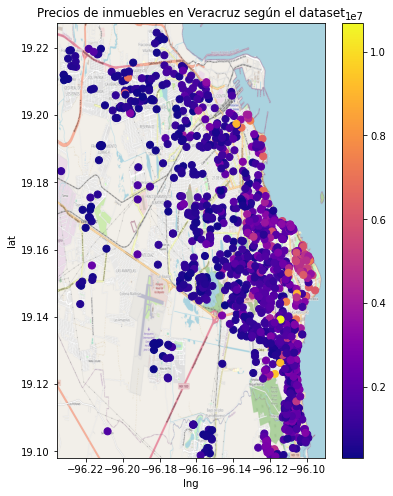

In [5]:
#Ploteo del mapa de VC con los datos del dataset
plot_map(df_train_VC, "original", "Precios de inmuebles en Veracruz según el dataset")

Queremos quedarnos con la zona costera, vamos a trazar una separacion en longitud = ?

(115, 23)
(50, 23)
(25, 23)
(76, 23)


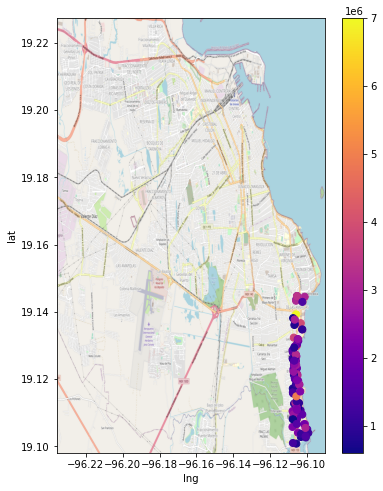

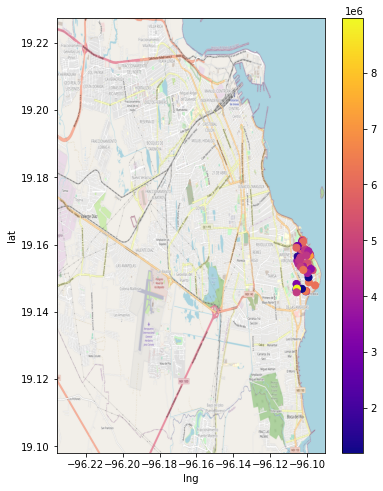

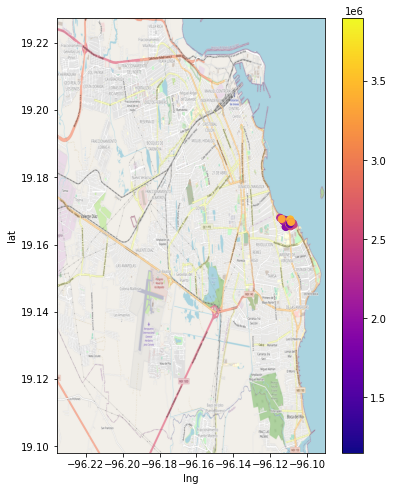

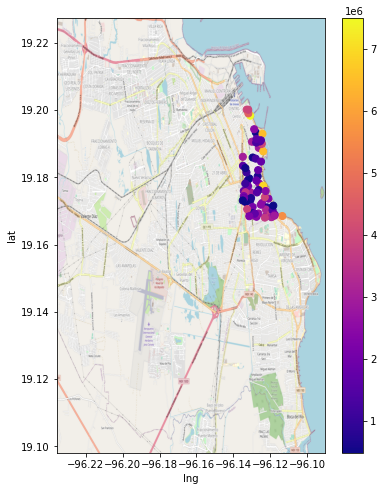

In [6]:
# PROBAMOS A MANO HASTA OBTENER TODA LA COSTA
df_train_VC_costa_1 = df_train_VC[(-96.108 <= df_train_VC["lng"]) & (19.145 >= df_train_VC["lat"])]
df_train_VC_costa_2 = df_train_VC[(-96.106 <= df_train_VC["lng"]) & ((19.145 <= df_train_VC["lat"]) &
                                                                     (19.165 >= df_train_VC["lat"])  )]
df_train_VC_costa_3 = df_train_VC[(-96.115 <= df_train_VC["lng"]) & ((19.165 <= df_train_VC["lat"]) &
                                                                     (19.168 >= df_train_VC["lat"])  )]
df_train_VC_costa_4 = df_train_VC[(-96.135 <= df_train_VC["lng"]) & ((19.168 <= df_train_VC["lat"]) )]

print(df_train_VC_costa_1.shape)
print(df_train_VC_costa_2.shape)
print(df_train_VC_costa_3.shape)
print(df_train_VC_costa_4.shape)
plot_map(df_train_VC_costa_1)
plot_map(df_train_VC_costa_2)
plot_map(df_train_VC_costa_3)
plot_map(df_train_VC_costa_4)

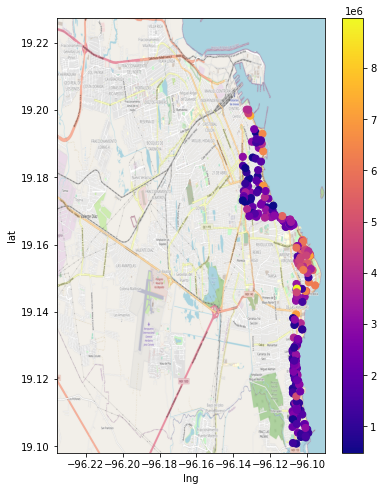

In [7]:
df_train_VC_costa = pd.concat([df_train_VC_costa_1,df_train_VC_costa_2,df_train_VC_costa_3,df_train_VC_costa_4])
plot_map(df_train_VC_costa)

In [8]:
print("Nos quedamos con la costa encontrada. Dimensiones:",df_train_VC_costa.shape)
df_train_VC_costa_y_piscina = df_train_VC_costa[df_train_VC_costa["piscina"]==1]
print("Ahora veamos las que además tienen pileta. Dimensiones:",df_train_VC_costa_y_piscina.shape)

Nos quedamos con la costa encontrada. Dimensiones: (266, 23)
Ahora veamos las que además tienen pileta. Dimensiones: (68, 23)


Hasta ahora teneos dos dataframes que tienen los datos de los anuncion que están en la costa y los que tienen piscina.
Vamos a asignar la nueva característica **amante_del_agua** de la siguiente forma:
- 0: si no tienen piscina ni están en la costa
- 1: si están cerca de la costa
- 2: si están cerca de la costa y tienen piscina

In [9]:
# Limpiamos en base al campo de los metroscubiertos
df_train_VC= df_train_VC[df_train_VC['metroscubiertos'].notna()]

In [10]:
amante_del_agua = []
print(df_train_VC.shape)
print("ESTO PUEDE TARDAR UNOS MINUTOS...")
for i in range(len(df_train_VC)):
    encontre = False
    for k in range(len(df_train_VC_costa)):
        #SI encontre la fila en los de la costa
        if df_train_VC.iloc[i]['id']==df_train_VC_costa.iloc[k]['id']:
            #SI ademas tiene piscina
            if df_train_VC.iloc[i]['piscina']==1:
                amante_del_agua.append(2)
            else: 
                amante_del_agua.append(1)
            encontre = True
            break;
    if not encontre:
        #SI no lo encontre entonces no tenia piscina ni estaba en la costa
        amante_del_agua.append(0)
        encontre = False
print(f"len(amante_del_agua): {len(amante_del_agua)}")

(1092, 23)
ESTO PUEDE TARDAR UNOS MINUTOS...
len(amante_del_agua): 1092


In [11]:
#Agregamos la nueva columna al dataframe
df_train_VC_new = df_train_VC
df_train_VC_new["amante_del_agua"] = amante_del_agua
df_train_VC_new.head(5)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,amante_del_agua
173,155331,"casa en venta, fracc. flores del valle, veracr...","casa con excelente ubicación, de dos plantas. ...",Casa,Lirio No. 01,Veracruz,Veracruz,10.0,3.0,2.0,...,19.145826,-96.139989,2014-12-18 00:00:00,0.0,0.0,0.0,0.0,0.0,1475000.0,0
483,63762,casa habitación,"casa recien remodelada, cocina ampliada. dos p...",Casa,Rio Rosas 88 Entre Río Panuco y Río Magdalena,Veracruz,Veracruz,5.0,2.0,1.0,...,19.207616,-96.195808,2014-08-05 00:00:00,0.0,0.0,0.0,1.0,1.0,495000.0,0
1094,162268,"departamentos en venta en boca del río, ver. p...",<p>torre n&aacute;utica es un desarrollo depar...,Apartamento,Boulevard Miguel Alemán #1489 Colonia Playa de...,Boca del Río,Veracruz,0.0,3.0,2.0,...,19.126671,-96.106396,2013-04-22 00:00:00,1.0,1.0,1.0,0.0,1.0,2700000.0,2
1551,273774,venta de departamento en fracc. virginia,departamento en condominio marcado con el núme...,Apartamento,NaN,Boca del Río,Veracruz,1.0,2.0,2.0,...,19.106273,-96.106320,2016-12-14 00:00:00,0.0,0.0,0.0,0.0,0.0,1510000.0,1
1573,225894,privada chile,"<p>casa nueva de 1 planta, 2 recámaras, 1 baño...",Casa,NaN,Veracruz,Veracruz,NaN,2.0,2.0,...,19.169215,-96.151554,2015-09-09 00:00:00,0.0,0.0,0.0,0.0,0.0,810000.0,0


### Correlación entre precio y amante_del_agua

In [12]:
print(df_train_VC_new['precio'].corr(df_train_VC_new['amante_del_agua']))

0.37623867120808974


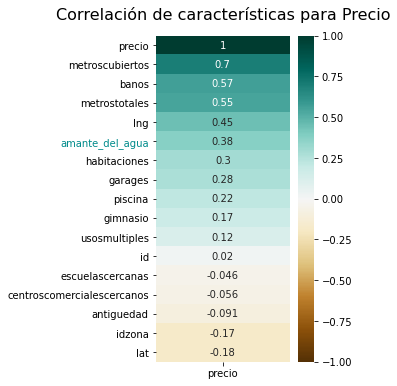

In [13]:
# Veamos las correlacione en gral
plt.figure(figsize=(3, 6))
heatmap = sns.heatmap(df_train_VC_new.corr()[['precio']].sort_values(by='precio', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlación de características para Precio', fontdict={'fontsize':16}, pad=16)

heatmap.get_yticklabels()[5].set_color("darkcyan")
plt.savefig("Exp3/Correlacion-de-caracteristicas-para-Precio.png", bbox_inches = "tight")

### Realizamos el fitteo con el viejo dataset y el nuevo

In [14]:
# Randomizamos los valores del DF y nos quedamos con un 20% para testing
cant_train = int((df_train_VC.shape[0] / 100) * 80)
shuffle = df_train_VC.sample(random_state=np.random.seed(46), frac=1)
new_train = shuffle.iloc[:cant_train, :]
new_test = shuffle.iloc[cant_train:df_train_VC.shape[0], :]
x_train, x_test = new_train[["lng", "lat", "metroscubiertos"]].values, new_test[["lng", "lat", "metroscubiertos"]].values
y_train, y_test = new_train["precio"].values, new_test["precio"].values

print(f"train: {x_train.shape}, test: {x_test.shape}")

# Ahora queremos entrenar el modelo (ESTO SOLO ES PARA DIBUJAR, deberia usar cross validation)
modelo = metnum.LinearRegression()
modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

train: (873, 3), test: (219, 3)


In [15]:
# Métricas del conjunto de training
results_VC = cross_validate(10, x_train, y_train, True, True)

RMSE = (923009.748846087, 202745.09727989143)
RMSLE = (0.4680055884863095, 0.04682433123470716)
R2 = (0.47447253438839343, 0.08357493893388672)


In [16]:
# Randomizo los valores del DF y me quedo con un 20% para testing
cant_train = int((df_train_VC_new.shape[0] / 100) * 80)
shuffle = df_train_VC_new.sample(random_state=np.random.seed(46), frac=1)
new_train = shuffle.iloc[:cant_train, :]
new_test = shuffle.iloc[cant_train:df_train_VC.shape[0], :]
x_train, x_test = new_train[["lng", "lat", "metroscubiertos", "amante_del_agua"]].values, new_test[["lng", "lat", "metroscubiertos", "amante_del_agua"]].values
y_train, y_test = new_train["precio"].values, new_test["precio"].values

print(f"train: {x_train.shape}, test: {x_test.shape}")

# Ahora queremos entrenar el modelo (ESTO SOLO ES PARA DIBUJAR, deberia usar cross validation)
modelo = metnum.LinearRegression()
modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

train: (873, 4), test: (219, 4)


In [17]:
# Mtricas del conjunto de training
results_VC_new = cross_validate(10, x_train, y_train, True, True)

RMSE = (852189.3042769923, 214989.30067830667)
RMSLE = (0.4407605817121395, 0.05892456585766787)
R2 = (0.5550036283979238, 0.08143353534385571)


#### Armamos las gráficas para interpretar mejor los resultados

In [18]:
df_results = pd.DataFrame.from_dict(results_VC)
# RMSLE
df_results_rmsle = pd.DataFrame(df_results["RMSLE"])
df_results_rmsle.columns = ["error"]
df_results_rmsle["metrica"] = ["RMSLE"]*df_results_rmsle.shape[0]
# RMSE
df_results_rmse = pd.DataFrame(df_results["RMSE"])
df_results_rmse.columns = ["error"]
df_results_rmse["metrica"] = ["RMSE"]*df_results_rmse.shape[0]

# Unimos los dataframes
df_results = pd.concat([df_results_rmsle, df_results_rmse])
df_results["con_nueva_feature"] = ["sin modificacion"]*df_results.shape[0]

df_results_new = pd.DataFrame.from_dict(results_VC_new)
# RMSLE
df_results_rmsle = pd.DataFrame(df_results_new["RMSLE"])
df_results_rmsle.columns = ["error"]
df_results_rmsle["metrica"] = ["RMSLE"]*df_results_rmsle.shape[0]
# RMSE
df_results_rmse = pd.DataFrame(df_results_new["RMSE"])
df_results_rmse.columns = ["error"]
df_results_rmse["metrica"] = ["RMSE"]*df_results_rmse.shape[0]

# Unimos los dataframes
df_results_new = pd.concat([df_results_rmsle, df_results_rmse])
df_results_new["con_nueva_feature"] = ["con feature nueva"]*df_results_new.shape[0]

# Concatenamos todo
df_results = pd.concat([df_results, df_results_new])
#display(df_results)

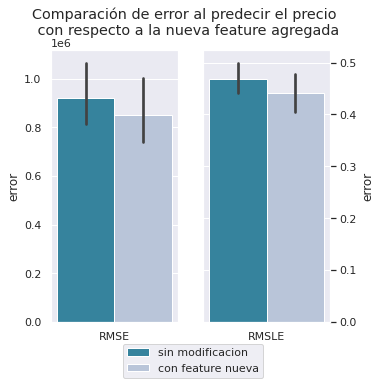

In [19]:
sns.set()

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(5, 5), sharey=False)
sns.barplot(ax=ax1, data=df_results[df_results["metrica"]=="RMSE"], y='error', x="metrica", hue="con_nueva_feature", palette="PuBuGn_r")
sns.barplot(ax=ax2, data=df_results[df_results["metrica"]=="RMSLE"], y='error', x="metrica", hue="con_nueva_feature", palette="PuBuGn_r")

ax1.get_legend().remove()
ax2.legend(bbox_to_anchor=(0.73,0.08), loc="lower", bbox_transform=fig.transFigure)
x_axis = ax1.xaxis.label.set_visible(False)
#ax1.set_title("RMSE")

ax2.yaxis.tick_right()
#y_axis = ax2.yaxis.label.set_visible(False)
ax2.yaxis.set_label_coords(1.35, 0.5)
x_axis = ax2.xaxis.label.set_visible(False)
#ax2.set_title("RMSLE")

fig.suptitle('Comparación de error al predecir el precio \n con respecto a la nueva feature agregada', y=1)
plt.savefig("Exp3/Comp-de-error-con-y-sin-nueva-feature.png", bbox_inches = "tight")

In [20]:
# R2
df_results = pd.DataFrame.from_dict(results_VC)
df_results_new = pd.DataFrame.from_dict(results_VC_new)

df_results_r2 = pd.DataFrame(df_results["R2"])
df_results_r2.columns = ["error"]
df_results_r2["con_nueva_feature"] = ["sin modificación"]*df_results_r2.shape[0]

df_results_r2_new = pd.DataFrame(df_results_new["R2"])
df_results_r2_new.columns = ["error"]
df_results_r2_new["con_nueva_feature"] = ["con nueva feature"]*df_results_r2_new.shape[0]

df_results = pd.concat([df_results_r2, df_results_r2_new])
df_results["metrica"] = ["R2"]*df_results.shape[0]
#display(df_results)

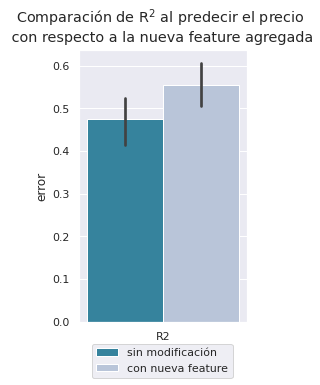

In [21]:
sns.set()

fig, ax = plt.subplots(1, 1, figsize=(3, 5), sharey=False)
sns.barplot(ax=ax, data=df_results, y='error', x="metrica", hue="con_nueva_feature", palette="PuBuGn_r")

x_axis = ax.xaxis.label.set_visible(False)
ax.legend(bbox_to_anchor=(0.86,0.08), loc="lower", bbox_transform=fig.transFigure)

fig.suptitle(r"Comparación de $\mathrm{R}^2$ al predecir el precio" + f"\n con respecto a la nueva feature agregada", y=1)
plt.savefig("Exp3/Comp-de-r2-con-y-sin-nueva-feature.png", bbox_inches = "tight")